# Access Data Filter
This file opens the pbf file downloaded from geofabrik and converts this data to make a heatmap using the isochrone apis.

## Steps followed:
1. Download the file from https://download.geofabrik.de/north-america.html
2. Filter the health ammenities using osmium tool
   ```bash
   osmium tags-filter us-latest.osm.pbf \
  nwr/amenity=hospital,clinic,doctors,dentist,pharmacy,nursing_home,veterinary,social_facility \
  nwr/healthcare \
  nwr/health_facility:type \
  -o health_filtered.osm.pbf --overwrite
   ```
3. Filter the highways using osmium tool
    ```bash
    osmium tags-filter us-latest.osm.pbf \
  w/highway \
  -o highways_only.osm.pbf
      ```
4. Paste this file in root directory and change the path accordingly in first code block

In [2]:
from pyrosm import OSM
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import cKDTree
import plotly.express as px
import osmnx as ox

### Bbox for limiting computations

In [10]:
bbox = [-81.040, 34.000, -81.020, 34.020]  # Roughly a 2km x 2km region

### Importing Healthcare facilites and visualizing it

In [3]:
# Load file (change path accordingly)
osm_hospital = OSM("health_filtered.osm.pbf")  # Downloaded from Geofabrik

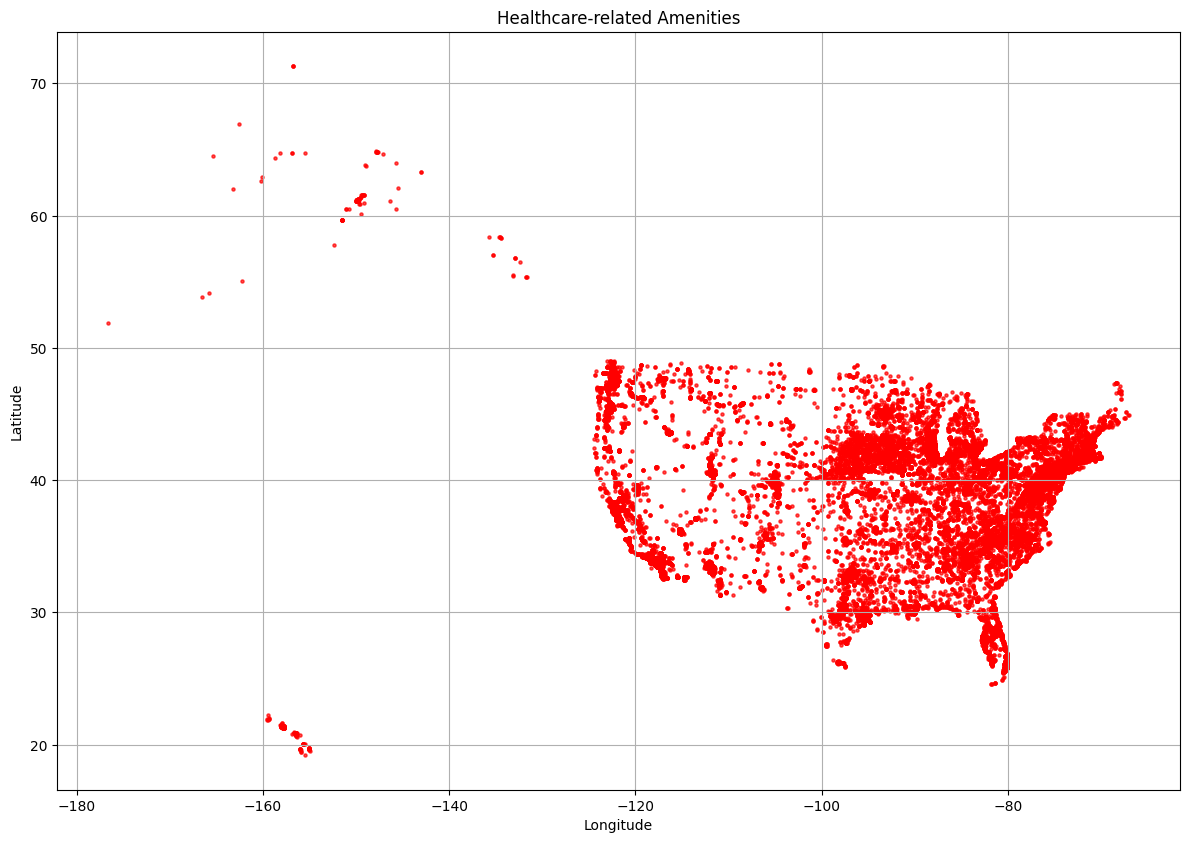

In [4]:
# Extract all POIs
pois = osm_hospital.get_pois()

# Filter only point geometries
pois = pois[pois.geometry.type == "Point"]

# Plotting using GeoPandas
fig, ax = plt.subplots(figsize=(12, 12))
pois.plot(ax=ax, color="red", markersize=5, alpha=0.7)

ax.set_title("Healthcare-related Amenities")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()


### Importing Pathways and visualizing it

<Axes: >

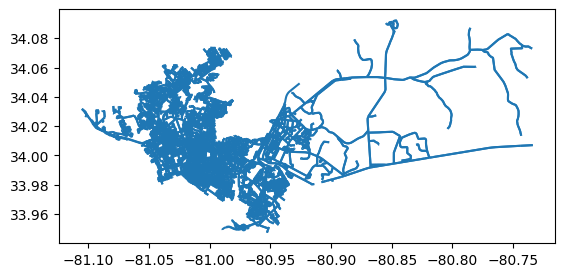

In [5]:
# Get road network for a city
G = ox.graph_from_place("Columbia, South Carolina, USA", network_type="drive")

# Convert to GeoDataFrame
edges = ox.graph_to_gdfs(G, nodes=False)
edges.plot()


In [15]:
# Project both to the same metric CRS (meters)
G_proj = ox.project_graph(G)
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)

pois = pois.to_crs(edges_proj.crs)

# Get nearest network node to each hospital
hospital_nodes = [
    ox.distance.nearest_nodes(G_proj, pt.x, pt.y)
    for pt in pois.geometry
]

In [16]:
# Get all nodes in the graph
all_nodes = list(G_proj.nodes)
access_distances = []

for node in all_nodes:
    try:
        # shortest path lengths from current node to all hospitals
        lengths = nx.single_source_dijkstra_path_length(G_proj, node, weight='length', cutoff=3000)
        # find the shortest one to a hospital
        dist_to_hospital = min([lengths.get(h, np.inf) for h in hospital_nodes])
        access_distances.append(dist_to_hospital)
    except:
        access_distances.append(np.inf)

# Add distances to nodes GeoDataFrame
nodes_proj["distance_to_hospital_m"] = access_distances
nodes_proj["accessibility_score"] = 1 / (nodes_proj["distance_to_hospital_m"] + 1)


/home/erwinschrodinger1/Developer/commons-care/analytics/env/lib/python3.13/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)
/tmp/ipykernel_198040/3666404545.py:44: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/erwinschrodinger1/Developer/commons-care/analytics/env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


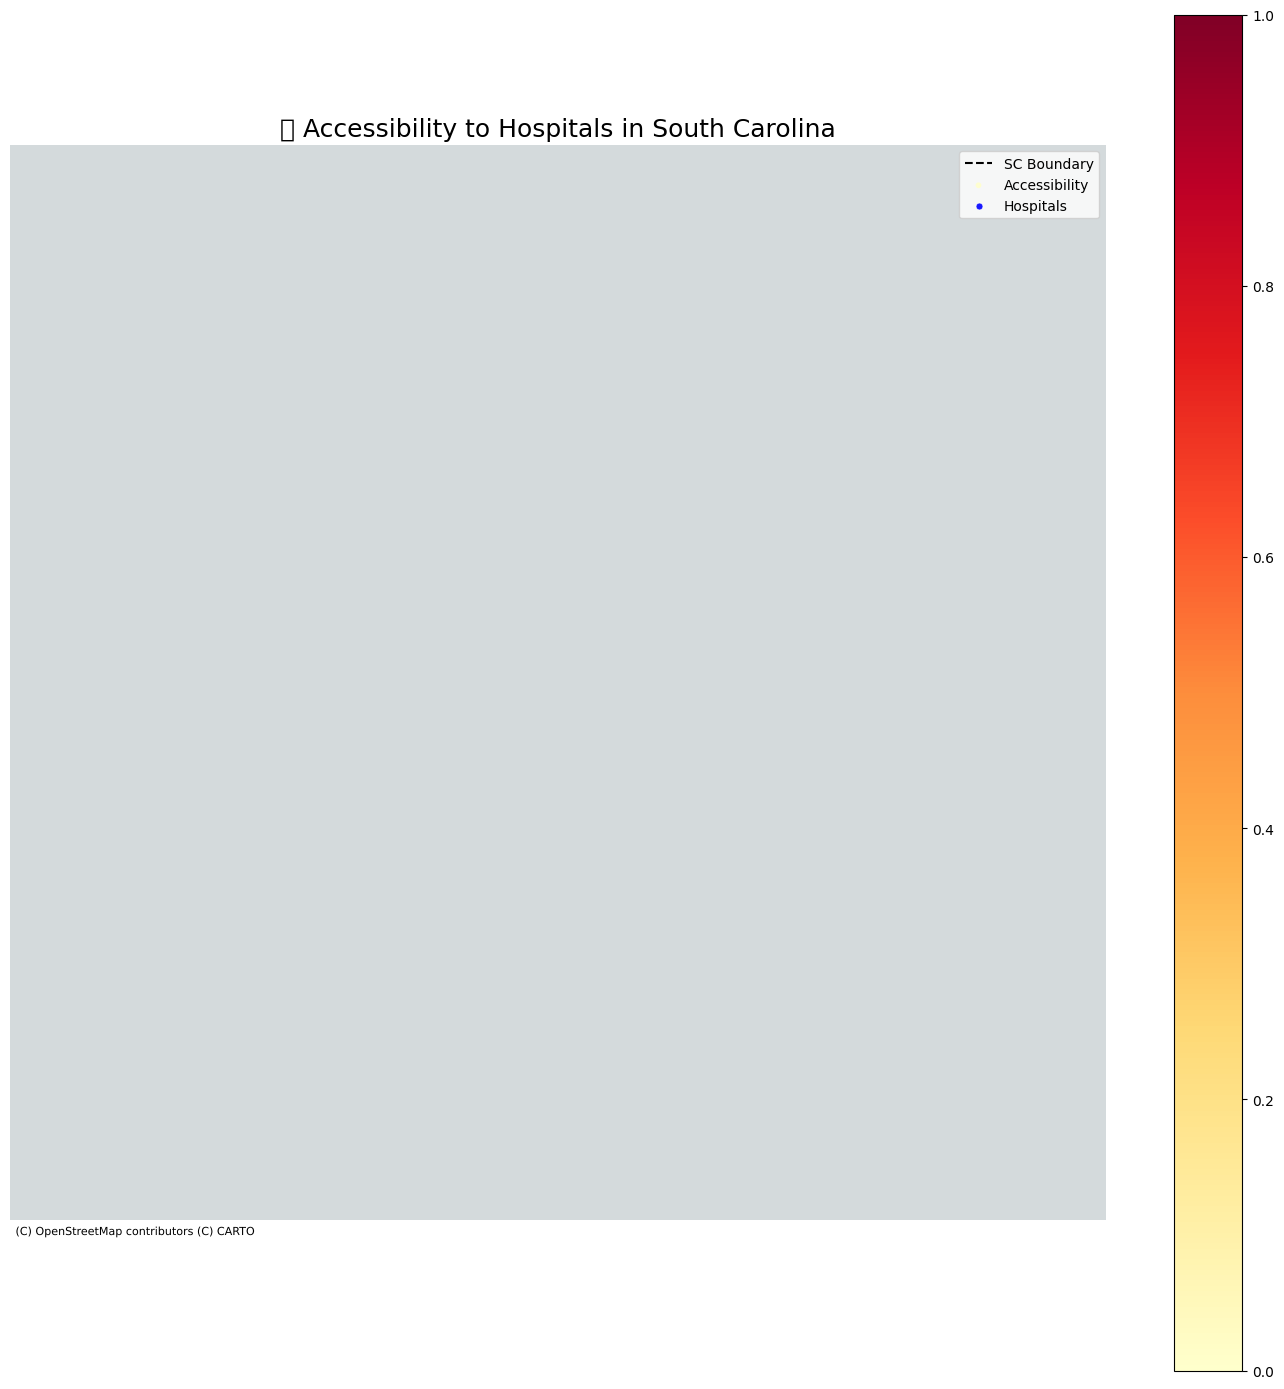

In [17]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx

# Step 1: Get administrative boundary of South Carolina
boundary = ox.geocode_to_gdf("South Carolina, USA").to_crs(nodes_proj.crs)

# Step 2: Set up the plot
fig, ax = plt.subplots(figsize=(14, 14))

# Step 3: Add basemap first (makes sure everything is on top)
ctx.add_basemap(ax, crs=nodes_proj.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Step 4: Plot boundary
boundary.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, linestyle='--', label="SC Boundary")

# Step 5: Plot accessibility heatmap (nodes)
nodes_proj.plot(
    ax=ax,
    column="accessibility_score",
    cmap="YlOrRd",
    markersize=10,
    legend=True,
    alpha=0.85,
    label="Accessibility"
)

# Step 6: Plot hospital POIs
pois.plot(
    ax=ax,
    color="blue",
    markersize=25,
    edgecolor="white",
    linewidth=0.5,
    label="Hospitals",
    alpha=0.9
)

# Step 7: Styling and labels
ax.set_title("🩺 Accessibility to Hospitals in South Carolina", fontsize=18)
ax.axis("off")
ax.legend(loc="upper right", fontsize=10, frameon=True)
plt.tight_layout()
plt.show()
